# Inference Endpoints (dedicated) 
_Authored by: [Moritz Laurer](https://huggingface.co/MoritzLaurer)_

Have you ever wanted to create your own machine learning API? That's what we will do in this recipe with the [HF Dedicated Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index). Inference Endpoints enable you to pick any of the hundreds of thousands of models on the HF Hub, create your own API on a deployment platform you control, and on hardware you choose.

[Serverless Inference APIs](link-to-recipe) are great for initial testing, but they are limited to a pre-configured selection of popular models and they are rate limited, because the serverless API's hardware is used by many users at the same time. With a Dedicated Inference Endpoint, you can customize the deployment of your model and the hardware is exclusively dedicated to you. 

In this recipe, we will: 
- Create an Inference Endpoint via a simple UI and send standard HTTP requests to the Endpoint
- Create and manage different Inference Endpoints programmatically with the `huggingface_hub` library
- Cover three use-cases: text generation with an LLM, image generation with Stable Diffusion, and reasoning over images with Idefics2. 

## Install and login
In case you don't have a HF Account, you can create your account [here](https://huggingface.co/join). If you work in a larger team, you can also create a [HF Organization](https://huggingface.co/organizations) and manage all your models, datasets and Endpoints via this organization. Dedicated Inference Endpoints are a paid service and you will therefore need to add a credit card to the [billing settings](https://huggingface.co/settings/billing) of your personal HF account, or of your HF organization.  

You can then create a user access token [here](https://huggingface.co/docs/hub/security-tokens). A token with `read` or `write` permissions will work for this guide, but we encourage the use of fine-grained tokens for increased security. For this notebook, you'll need a fine-grained token with `User Permissions > Inference > Make calls to Inference Endpoints & Manage Inference Endpoints` and `Repository permissions > google/gemma-1.1-2b-it & HuggingFaceM4/idefics2-8b-chatty`.

In [ ]:
!pip install huggingface_hub~=0.23.3
!pip install transformers~=4.41.2

In [ ]:
# Login to the HF Hub. We recommend using this login method 
# to avoid the need for explicitly storing your HF token in variables 
import huggingface_hub
huggingface_hub.interpreter_login()

## Creating your first Endpoint

With this initial setup out of the way, we can now create our first Endpoint. Navigate to https://ui.endpoints.huggingface.co/ and click on `+ New` next to `Dedicated Endpoints`. You will then see the interface for creating a new Endpoint with the following options (see image below):

- **Model Repository**: Here you can insert the identifier of any model on the HF Hub. For this initial demonstration, we use [google/gemma-1.1-2b-it](https://huggingface.co/google/gemma-1.1-2b-it), a small generative LLM (2.5B parameters). 
- **Endpoint Name**: The Endpoint Name is automatically generated based on the model identifier, but you are free to change the name. Valid Endpoint names must only contain lower-case characters, numbers or hyphens ("-") and are between 4 to 32 characters long.
- **Instance Configuration**: Here you can choose from a wide range of CPUs or GPUs from all major cloud platforms. You can also adjust the region, for example if you need to host your Endpoint in the EU. 
- **Automatic Scale-to-Zero**: You can configure your Endpoint to scale to zero GPUs/CPUs after a certain amount of time. Scaled-to-zero Endpoints are not billed anymore. Note that restarting the Endpoint requires the model to be re-loaded into memory (and potentially re-downloaded), which can take several minutes for large models. 
- **Endpoint Security Level**: The standard security level is `Protected`, which requires an authorized HF token for accessing the Endpoint. `Public` Endpoints are accessible by anyone without token authentification. `Private` Endpoints are only available through an intra-region secured AWS or Azure PrivateLink connection.
- **Advanced configuration**: Here you can select some advanced options like the Docker container type. As Gemma is compatible with [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/index) containers, the system automatically selects TGI as the container type and other good default values.

For this guide, select the options in the image below and click on `Create Endpoint`. 


<div style="display: flex; justify-content: center !important;">
    <img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/enterprise-endpoints-creation.png">  
</div>

After roughly one minute, your Endpoint will be created and you will see a page similar to the image below. 

On the Endpoint's `Overview` page, will find the URL for querying the Endpoint, a Playground for testing the model and additional tabs on `Analytics`, `Usage & Cost`, `Logs`and `Settings`.  

<div style="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/enterprise-endpoint-overviewpage.png">  
</div>


### Creating and managing Endpoints programmatically

When moving into production, you don't always want to manually start, stop and modify your Endpoints. The `huggingface_hub` library provides good functionality for managing your Endpoints programmatically. See the docs [here](https://huggingface.co/docs/huggingface_hub/guides/inference_endpoints) and details on all functions [here](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_endpoints). Here are some key functions:


In [ ]:
# list all your inference endpoints
huggingface_hub.list_inference_endpoints()

# get an existing endpoint and check it's status
endpoint = huggingface_hub.get_inference_endpoint(
    name="gemma-1-1-2b-it-yci",  # the name of the endpoint 
    namespace="MoritzLaurer"  # your user name or organization name
)
print(endpoint)

# Pause endpoint to stop billing
endpoint.pause()

# Resume and wait until the endpoint is ready
#endpoint.resume()
#endpoint.wait()

# Update the endpoint to a different GPU
# You can find the correct arguments for different hardware types in this table: https://huggingface.co/docs/inference-endpoints/pricing#gpu-instances
#endpoint.update(
#    instance_size="x1",
#    instance_type="nvidia-a100",  # nvidia-a10g
#)

You can also create an inference Endpoint programmatically. Let's recreate the same `gemma` LLM Endpoint as the one created with the UI.

In [ ]:
from huggingface_hub import create_inference_endpoint


model_id = "google/gemma-1.1-2b-it"
endpoint_name = "gemma-1-1-2b-it-001"  # Valid Endpoint names must only contain lower-case characters, numbers or hyphens ("-") and are between 4 to 32 characters long.
namespace = "MoritzLaurer"  # your user or organization name


# check if endpoint with this name already exists from previous tests
available_endpoints_names = [endpoint.name for endpoint in huggingface_hub.list_inference_endpoints()]
if endpoint_name in available_endpoints_names:
    endpoint_exists = True
else: 
    endpoint_exists = False
print("Does the endpoint already exist?", endpoint_exists)
    

# create new endpoint
if not endpoint_exists:
    endpoint = create_inference_endpoint(
        endpoint_name,
        repository=model_id,
        namespace=namespace,
        framework="pytorch",
        task="text-generation",
        # see the available hardware options here: https://huggingface.co/docs/inference-endpoints/pricing#pricing
        accelerator="gpu",
        vendor="aws",
        region="us-east-1",
        instance_size="x1",
        instance_type="nvidia-a10g",
        min_replica=0,
        max_replica=1,
        type="protected",
        # since the LLM is compatible with TGI, we specify that we want to use the latest TGI image
        custom_image={
            "health_route": "/health",
            "env": {
                "MODEL_ID": "/repository"
            },
            "url": "ghcr.io/huggingface/text-generation-inference:latest",
        },
    )
    print("Waiting for endpoint to be created")
    endpoint.wait()
    print("Endpoint ready")

# if endpoint with this name already exists, get and resume existing endpoint
else:
    endpoint = huggingface_hub.get_inference_endpoint(name=endpoint_name, namespace=namespace)
    if endpoint.status in ["paused", "scaledToZero"]:
        print("Resuming endpoint")
        endpoint.resume()
    print("Waiting for endpoint to start")
    endpoint.wait()
    print("Endpoint ready")

In [ ]:
# access the endpoint url for API calls
print(endpoint.url)

## Querying your Endpoint

Now let's query this Endpoint like any other LLM API. First copy the Endpoint URL from the interface (or use `endpoint.url`) and assign it to `API_URL` below. We then use the standardised messages format for the text inputs, i.e. a dictionary of user and assistant messages, which you might know from other LLM API services. We then need to apply the chat template to the messages, which LLMs like Gemma, Llama-3 etc. have been trained to expect (see details on in the [docs](https://huggingface.co/docs/transformers/main/en/chat_templating)). For most recent generative LLMs, it is essential to apply this chat template, otherwise the model's performance will degrade without throwing an error. 

In [5]:
import requests
from transformers import AutoTokenizer

# paste your endpoint URL here or reuse endpoint.url if you created the endpoint programmatically
API_URL = endpoint.url  # or paste link like "https://dz07884a53qjqb98.us-east-1.aws.endpoints.huggingface.cloud" 
HEADERS = {"Authorization": f"Bearer {huggingface_hub.get_token()}"}

# function for standard http requests
def query(payload=None, api_url=None):
    response = requests.post(api_url, headers=HEADERS, json=payload)
    return response.json()


# define conversation input in messages format
# you can also provide multiple turns between user and assistant
messages = [
    {"role": "user", "content": "Please write a short poem about open source for me."},
    #{"role": "assistant", "content": "I am not in the mood."},
    #{"role": "user", "content": "Can you please do this for me?"},
]

# apply the chat template for the respective model
model_id = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id) 
messages_with_template = tokenizer.apply_chat_template(messages, tokenize=False)
print("Your text input looks like this, after the chat template has been applied:\n")
print(messages_with_template)

Your text input looks like this, after the chat template has been applied:

<bos><start_of_turn>user
Please write a short poem about open source for me.<end_of_turn>



In [6]:
# send standard http request to endpoint
output = query(
    payload = {
        "inputs": messages_with_template,
        "parameters": {"temperature": 0.2, "max_new_tokens": 100, "seed": 42, "return_full_text": False},
    },
    api_url = API_URL
)

print("The output from your API/Endpoint call:\n")
print(output)

The output from your API/Endpoint call:

[{'generated_text': "Free to use, free to share,\nA collaborative code, a community's care.\n\nCode transparent, bugs readily found,\nContributions welcome, stories unbound.\nOpen source, a gift to all,\nBuilding the future, one line at a call.\n\nSo join the movement, embrace the light,\nOpen source, shining ever so bright."}]


That's it, you've made the first request to your Endpoint - your very own API!

If you want the Endpoint to handle the chat template automatically and if your LLM runs on a TGI container, you can also use the [messages API](https://huggingface.co/docs/text-generation-inference/en/messages_api) by appending the `/v1/chat/completions` path to the URL. With the `/v1/chat/completions` path, the [TGI](https://huggingface.co/docs/text-generation-inference/index) container running on the Endpoint applies the chat template automatically and is fully compatible with OpenAI's API structure for easier interoperability. See the [TGI Swagger UI](https://huggingface.github.io/text-generation-inference/#/Text%20Generation%20Inference/chat_completions) for all available parameters. Note that the parameters accepted by the default `/` path and by the `/v1/chat/completions` path are slightly different. Here is the slightly modified code for using the messages API:

In [7]:
API_URL_CHAT = API_URL + "/v1/chat/completions"

output = query(
    payload = {
        "messages": messages,
        "model": "tgi",
        "parameters": {"temperature": 0.2, "max_tokens": 100, "seed": 42},
    },
    api_url = API_URL_CHAT
)

print("The output from your API/Endpoint call with the OpenAI-compatible messages API route:\n")
print(output)


The output from your API/Endpoint call with the OpenAI-compatible messages API route:

{'id': '', 'object': 'text_completion', 'created': 1718283608, 'model': '/repository', 'system_fingerprint': '2.0.5-dev0-sha-90184df', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '**Open Source**\n\nA license for the mind,\nTo share, distribute, and bind,\nIdeas freely given birth,\nFor the good of all to sort.\n\nCode transparent, eyes open wide,\nA permission for the wise,\nTo learn, to build, to use at will,\nA future bright, we help fill.\n\nFrom servers vast to candles low,\nOpen source, a guiding key,\nFor progress made, knowledge shared,\nA future brimming with'}, 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 20, 'completion_tokens': 100, 'total_tokens': 120}}


### Simplified Endpoint usage with the InferenceClient

You can also use the [`InferenceClient`](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_client#huggingface_hub.InferenceClient) to easily send requests to your Endpoint. The client is a convenient utility available in the `huggingface_hub` Python library that allows you to easily make calls to both [Dedicated Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) and the [Serverless Inference API](https://huggingface.co/docs/api-inference/index). See the [docs](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_client#inference) for details. 

This is the most succinct way of sending requests to your Endpoint:

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient()

output = client.chat_completion(
    messages,  # the chat template is applied automatically, if your endpoint uses a TGI container
    model=API_URL, 
    temperature=0.2, max_tokens=100, seed=42,
)

print("The output from your API/Endpoint call with the InferenceClient:\n")
print(output)

In [ ]:
# pause the endpoint to stop billing
#endpoint.pause()

## Creating Endpoints for a wide variety of models
Following the same process, you can create Endpoints for any of the models on the HF Hub. Let's illustrate some other use-cases.

### Image generation with Stable Diffusion
We can create an image generation Endpoint with almost the exact same code as for the LLM. The only difference is that we do not use the TGI container in this case, as TGI is only designed for LLMs (and vision LMs). 

In [7]:
!pip install Pillow  # for image processing

     |████████████████████████████████| 4.5 MB 24.7 MB/s eta 0:00:01


In [6]:
from huggingface_hub import create_inference_endpoint

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
endpoint_name = "stable-diffusion-xl-base-1-0-001"  # Valid Endpoint names must only contain lower-case characters, numbers or hyphens ("-") and are between 4 to 32 characters long.
namespace = "MoritzLaurer"  # your user or organization name
task = "text-to-image"

# check if endpoint with this name already exists from previous tests
available_endpoints_names = [endpoint.name for endpoint in huggingface_hub.list_inference_endpoints()]
if endpoint_name in available_endpoints_names:
    endpoint_exists = True
else: 
    endpoint_exists = False
print("Does the endpoint already exist?", endpoint_exists)
    

# create new endpoint
if not endpoint_exists:
    endpoint = create_inference_endpoint(
        endpoint_name,
        repository=model_id,
        namespace=namespace,
        framework="pytorch",
        task=task,
        # see the available hardware options here: https://huggingface.co/docs/inference-endpoints/pricing#pricing
        accelerator="gpu",
        vendor="aws",
        region="us-east-1",
        instance_size="x1",
        instance_type="nvidia-a100",
        min_replica=0,
        max_replica=1,
        type="protected",
    )
    print("Waiting for endpoint to be created")
    endpoint.wait()
    print("Endpoint ready")

# if endpoint with this name already exists, get existing endpoint
else:
    endpoint = huggingface_hub.get_inference_endpoint(name=endpoint_name, namespace=namespace)
    if endpoint.status in ["paused", "scaledToZero"]:
        print("Resuming endpoint")
        endpoint.resume()
    print("Waiting for endpoint to start")
    endpoint.wait()
    print("Endpoint ready")

    

Does the endpoint already exist? True
Waiting for endpoint to start
Endpoint ready


PROMPT:  A whimsical illustration of a fashionably dressed llama proudly holding a worn, vintage cookbook, with a warm cup of tea and a few freshly baked treats scattered around, set against a cozy background of rustic wood and blooming flowers.


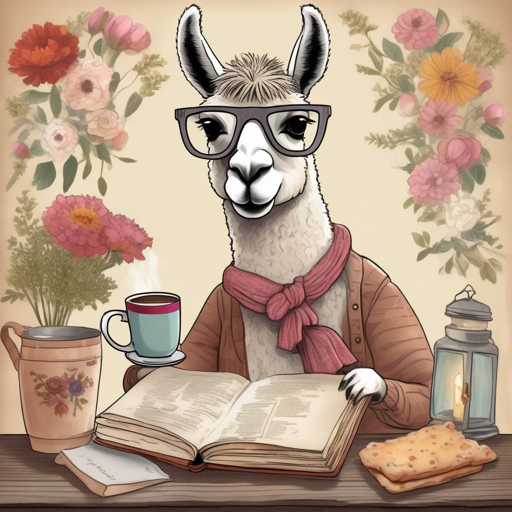

In [7]:
prompt = "A whimsical illustration of a fashionably dressed llama proudly holding a worn, vintage cookbook, with a warm cup of tea and a few freshly baked treats scattered around, set against a cozy background of rustic wood and blooming flowers."

image = client.text_to_image(
    prompt=prompt,
    model=endpoint.url,  #"stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
)

print("PROMPT: ", prompt)
display(image.resize((image.width // 2, image.height // 2)))

We pause the Endpoint again to stop billing. 

In [ ]:
endpoint.pause()

### Vision Language Models: Reasoning over text and images

Now let's create an Endpoint for a vision language model (VLM). VLMs are very similar to LLMs, only that they can take both text and images as input simultaneously. Their output is autoregressively generated text, just like for a standard LLM. VLMs can tackle many tasks from visual question answering to document understanding. For this example, we use [Idefics2](https://huggingface.co/blog/idefics2), a powerful 8B parameter VLM. 

We first need to convert our PIL image generated with Stable Diffusion to a `base64` encoded string so that we can send it to the model over the network.

In [8]:
import base64
from io import BytesIO


def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


image_b64 = pil_image_to_base64(image)

Because VLMs and LLMs are so similar, we can use almost the same messages format and chat template again, only with some additional code for including the image in the prompt. See the [Idefics2 model card](https://huggingface.co/HuggingFaceM4/idefics2-8b) for specific details on prompt formatting. 

In [ ]:
from transformers import AutoProcessor

# load the processor
model_id_vlm = "HuggingFaceM4/idefics2-8b-chatty"
processor = AutoProcessor.from_pretrained(model_id_vlm)

# define the user messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},  # the image is placed here in the prompt. You can add multiple images throughout the conversation.
            {"type": "text", "text": "Write a short limerick about this image."},
        ],
    },
]

# apply the chat template to the messages
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

# the chat template places a special "<image>" token at the position where the image should go
# here we replace the "<image>" token with the base64 encoded image string in the prompt
# to be able to send the image via an API request
image_input = f"data:image/jpeg;base64,{image_b64}"
image_input = f"![]({image_input})"
prompt = prompt.replace("<image>", image_input)

> [!TIP]
> For VLMs, an image represents a certain amount of tokens. For Idefics2, for example, one image represents 64 tokens at low resolution and 5*64=320 tokens in high resolution. High resolution is the default in TGI (see `do_image_splitting` in the [model card](https://huggingface.co/HuggingFaceM4/idefics2-8b-chatty) for details). This means that one image consumed 320 tokens. 

Several VLMs like Idefics2 are also supported by TGI (see [list of supported models](https://huggingface.co/docs/text-generation-inference/supported_models)), so we use the TGI container again when creating the Endpoint. 


In [10]:
from huggingface_hub import create_inference_endpoint

endpoint_name = "idefics2-8b-chatty-001"
namespace = "MoritzLaurer"
task = "text-generation"

# check if endpoint with this name already exists from previous tests
available_endpoints_names = [endpoint.name for endpoint in huggingface_hub.list_inference_endpoints()]
if endpoint_name in available_endpoints_names:
    endpoint_exists = True
else: 
    endpoint_exists = False
print("Does the endpoint already exist?", endpoint_exists)
    

if endpoint_exists:
    endpoint = huggingface_hub.get_inference_endpoint(name=endpoint_name, namespace=namespace)
    if endpoint.status in ["paused", "scaledToZero"]:
        print("Resuming endpoint")
        endpoint.resume()
    print("Waiting for endpoint to start")
    endpoint.wait()
    print("Endpoint ready")

else:
    endpoint = create_inference_endpoint(
        endpoint_name,
        repository=model_id_vlm,
        namespace=namespace,
        framework="pytorch",
        task=task,
        accelerator="gpu",
        vendor="aws",
        region="us-east-1",
        type="protected",
        instance_size="x1",
        instance_type="nvidia-a100",
        min_replica=0,
        max_replica=1,
        custom_image={
            "health_route": "/health",
            "env": {
                "MAX_BATCH_PREFILL_TOKENS": "2048",
                "MAX_INPUT_LENGTH": "1024",
                "MAX_TOTAL_TOKENS": "1536",
                "MODEL_ID": "/repository"
            },
            "url": "ghcr.io/huggingface/text-generation-inference:latest",
        },
    )

    print("Waiting for endpoint to be created")
    endpoint.wait()
    print("Endpoint ready")

Does the endpoint already exist? False
Waiting for endpoint to be created
Endpoint ready


In [11]:
output = client.text_generation(
    prompt, model=model_id_vlm, max_new_tokens=200, seed=42
)

print(output)

 In a quaint little café, there lived a llama,
With glasses on his face, he was quite a charm.
He'd sit at the table,
With a book and a mable,
And sip from a cup of warm tea.


In [ ]:
endpoint.pause()

## Additional information
- When creating several Endpoints, you will probably get an error message that your GPU quota has been reached. Don't hesitate to send a message to the email address in the error message and we will most likely increase your GPU quota.
- What is the difference between `paused` and `scaled-to-zero` Endpoints? `scaled-to-zero` Endpoints can be flexibly woken up and scaled up by user requests, while `paused` Endpoints need to be unpaused by the creator of the Endpoint. Moreover, `scaled-to-zero` Endpoints count towards your GPU quota (with the maximum possible replica it could be scaled up to), while `paused` Endpoints do not. A simple way of freeing up your GPU quota is therefore to pause some Endpoints.  

## Conclusion and next steps

That's it, you've created three different Endpoints (your own APIs!) for text-to-text, text-to-image, and image-to-text generation and the same is possible for many other models and tasks. 

We encourage you to read the Dedicated Inference Endpoint [docs](https://huggingface.co/docs/inference-endpoints/index) to learn more. If you are using generative LLMs and VLMs, we also recommend reading the TGI [docs](https://huggingface.co/docs/text-generation-inference/index), as the most popular LLMs/VLMs are also supported by TGI, which makes your Endpoints significantly more efficient. 

You can, for example, use **JSON-mode or function calling** with open-source models via [TGI Guidance](https://huggingface.co/docs/text-generation-inference/basic_tutorials/using_guidance) (see also this [recipe](https://huggingface.co/learn/cookbook/structured_generation) for an example for RAG with structured generation). 

When moving your Endpoints into production, you will want to make several additional improvements to make your setup more efficient. When using TGI, you should send batches of requests to the Endpoint with asynchronous function calls to fully utilize the Endpoint's hardware and you can adapt several container parameters to optimize latency and throughput for your use-case. We will cover these optimizations in another recipe. 


